# Лабораторная работа №3: LogReg

## Задание 1
Используя функцию make_blobs с любым random_state, сгенерировать датасет df, в
котором есть три класса с размером каждого класса 100 объектов и восемь
количественных (недискретных) признаков, при этом центры классов зафиксированы в
следующих точках: Класс 0 – (+1,+1,+1,+1,+1,+1,+1,+1), Класс 1 – (-1,-1,-1,-1,-1,-1,-1,-1),
Класс 2 – (+1,-1,+1,-1,+1,-1,+1,-1).  

__Не забываем повторять шаги задания 1:__
- ключевые характеристики датасета
- корреляции
- визуализация на всех парах переменных

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.datasets import make_blobs
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from matplotlib.markers import MarkerStyle
import seaborn as sns

In [2]:
PALETTE = "crest"


def describe_dataset(df: pd.DataFrame, hue: str) -> pd.DataFrame:
    class_labels = df[hue].unique().tolist()
    col_names = ["Size", "Features", "Classes"] + class_labels + ["Undefined"]
    undefined = round((df.isna().any(axis=1).sum() / df.shape[0]) * 100, 3)
    cells = [[df.shape[0], len(df.columns) - 1, len(class_labels)] + df[hue].value_counts().to_list() + [undefined]]
    return pd.DataFrame(cells, columns=col_names)

In [3]:
centers = np.array([np.repeat(1, 8), np.repeat(-1, 8), [1 if (i % 2) == 0 else -1 for i in range(8)]])
X, y = make_blobs(300, 8, centers=centers, random_state=42, shuffle=False)

df = pd.DataFrame(np.concat((X, y.reshape(-1, 1)), 1))
df.rename(columns=lambda i: f"Feature_{i}" if i != 8 else "Class", inplace=True)

print("Common inforamtion about df:")
print(describe_dataset(df, "Class"))

Common inforamtion about df:
   Size  Features  Classes  0.0  1.0  2.0  Undefined
0   300         8        3  100  100  100        0.0


### Визуализация распределения сгенерированного датасета

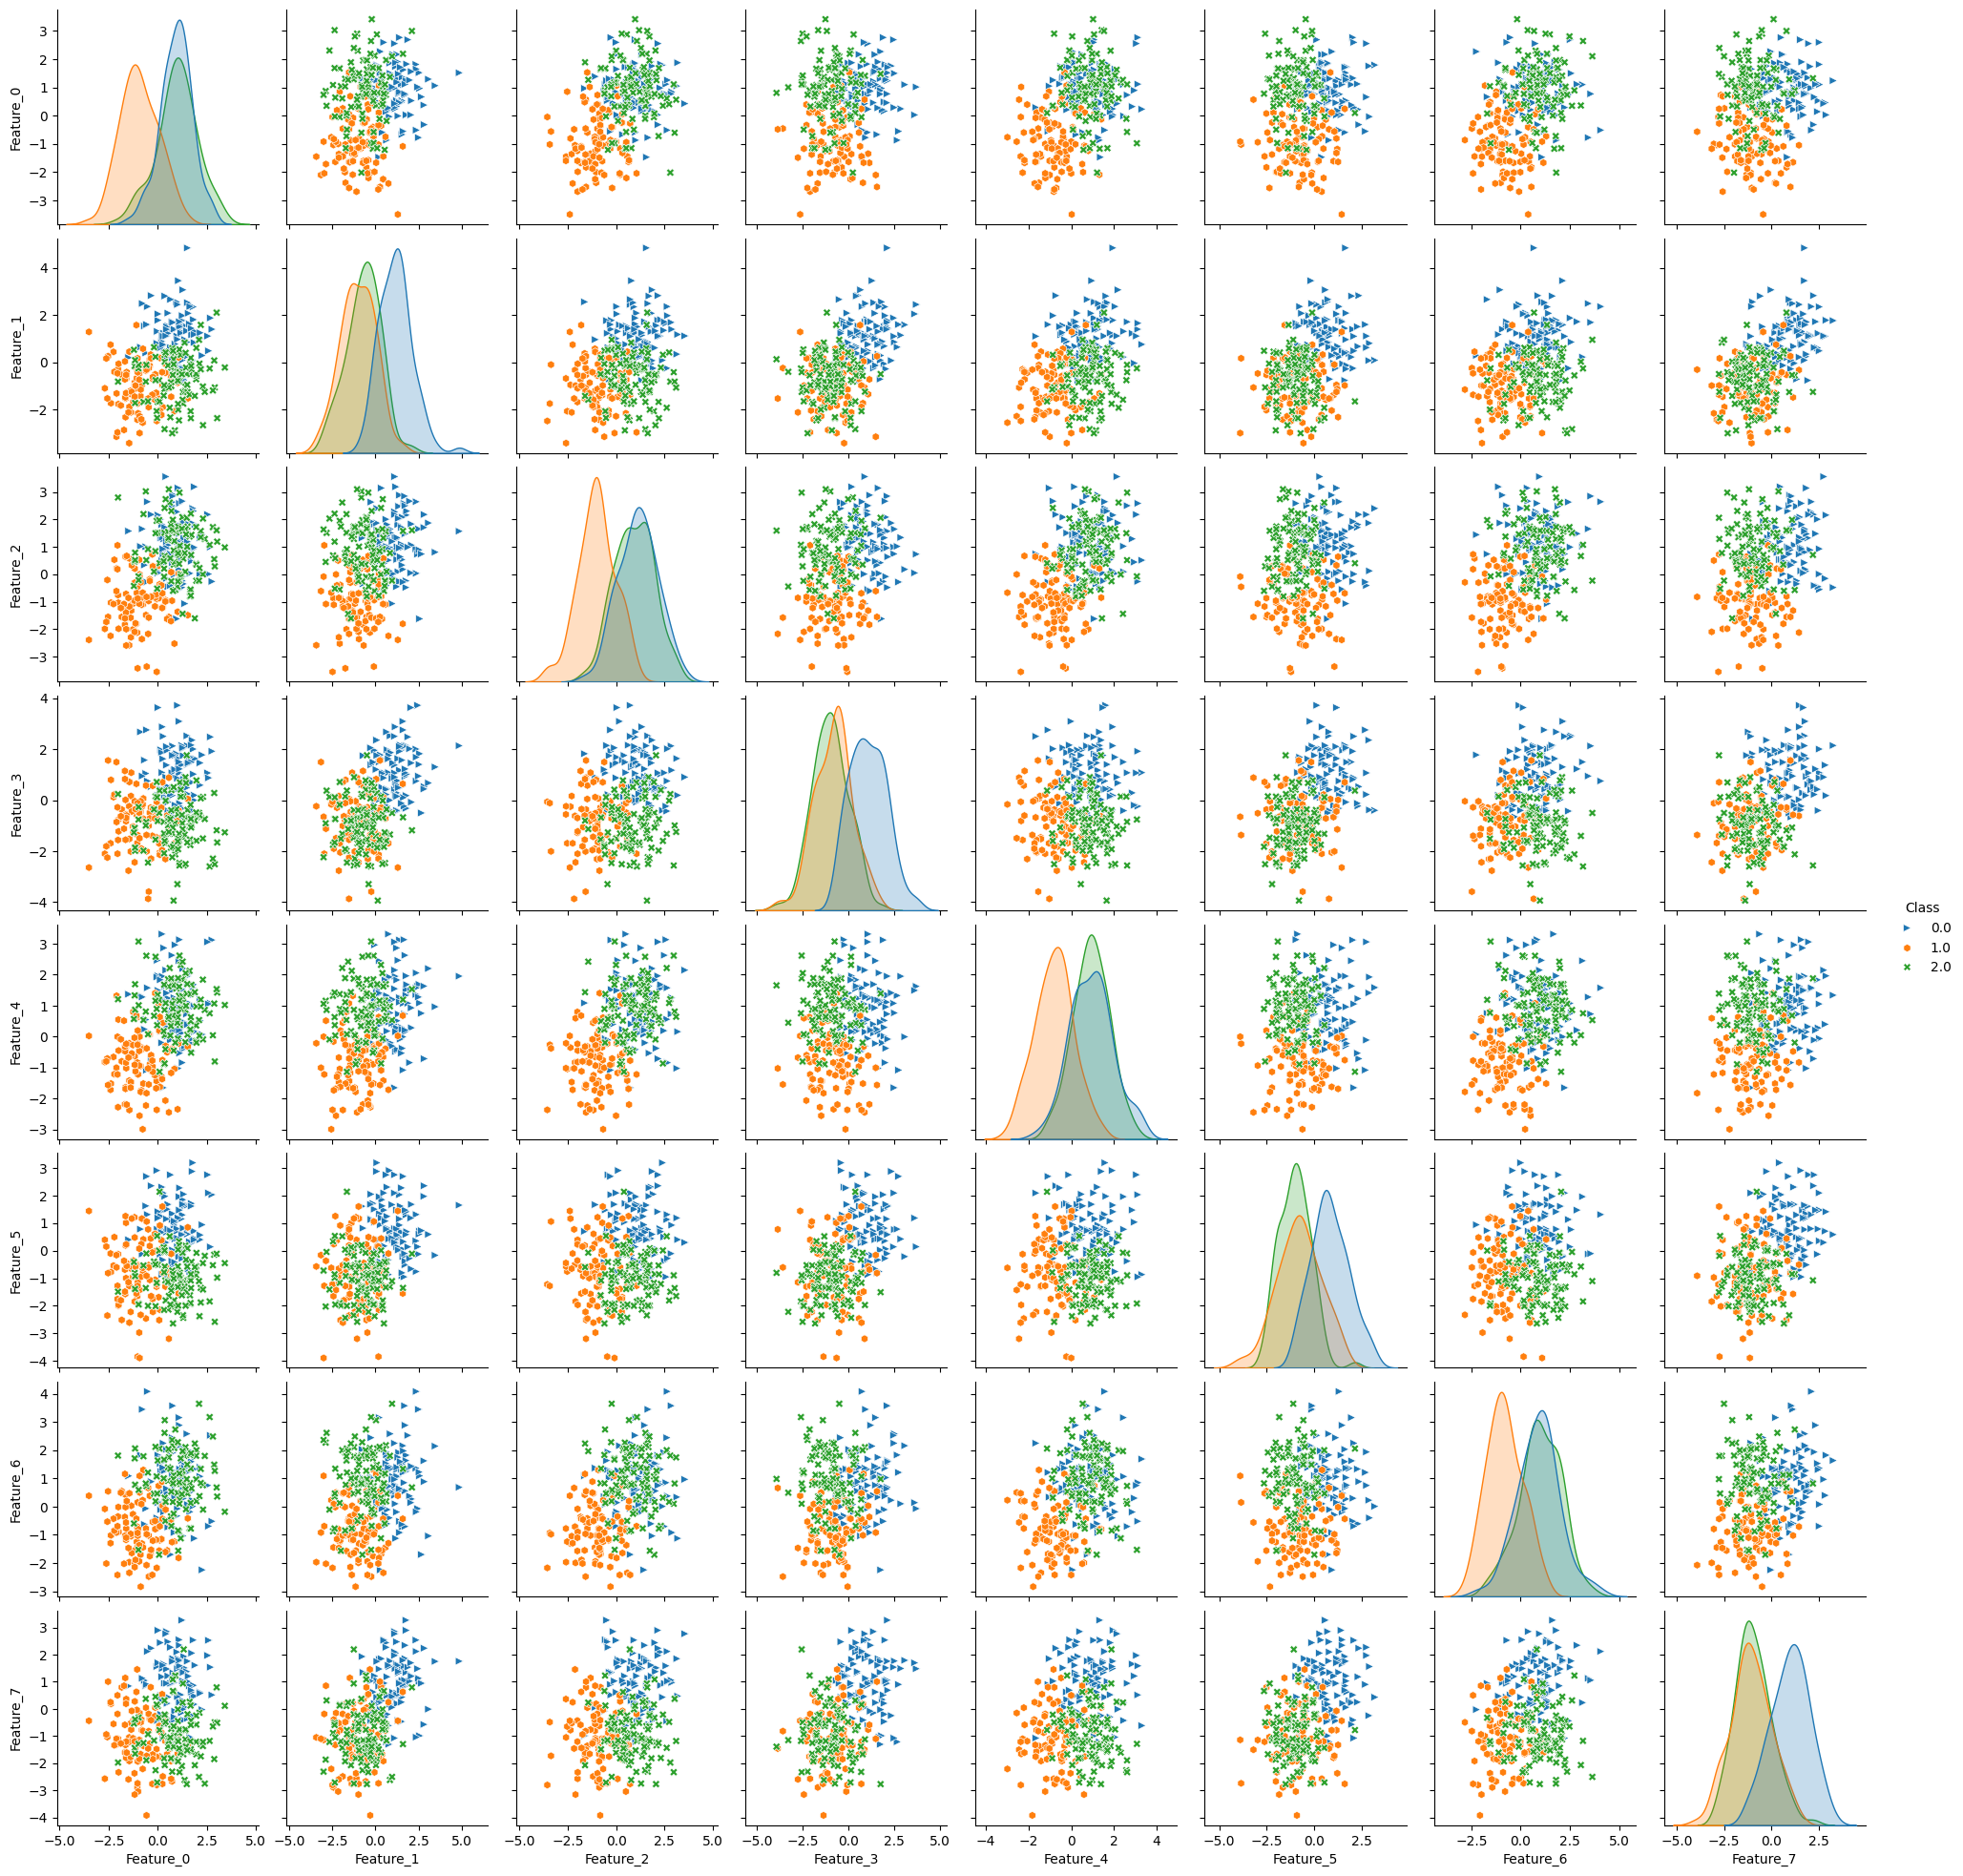

In [85]:
class_labels = df["Class"].unique().tolist()
class_markers = {}
class_colors = {}
for i, class_label in enumerate(class_labels):
    class_markers[class_label] = MarkerStyle.filled_markers[(i + 1) * 5]
    class_colors[class_label] = f"C{i}"

sns.pairplot(df, hue="Class", markers=list(class_markers.values()), palette=class_colors)
plt.show()

### Демонстрация матриц корреляций по всем признакам



PEARSON

All objects:
    feature_1  feature_2      corr       p_value
0   Feature_0  Feature_0  1.000000  0.000000e+00
1   Feature_0  Feature_1  0.292731  2.435321e-07
2   Feature_0  Feature_2  0.466759  1.228566e-17
3   Feature_0  Feature_3  0.190384  9.192648e-04
4   Feature_0  Feature_4  0.436194  2.301016e-15
..        ...        ...       ...           ...
59  Feature_7  Feature_3  0.457769  6.047805e-17
60  Feature_7  Feature_4  0.263195  3.811930e-06
61  Feature_7  Feature_5  0.432036  4.506298e-15
62  Feature_7  Feature_6  0.253800  8.559990e-06
63  Feature_7  Feature_7  1.000000  0.000000e+00

[64 rows x 4 columns]

0.0:
    feature_1  feature_2      corr   p_value
0   Feature_0  Feature_0  1.000000  0.000000
1   Feature_0  Feature_1 -0.020261  0.841419
2   Feature_0  Feature_2 -0.014819  0.883656
3   Feature_0  Feature_3  0.044438  0.660658
4   Feature_0  Feature_4  0.025146  0.803872
..        ...        ...       ...       ...
59  Feature_7  Feature_3 -0.028275  0.780050

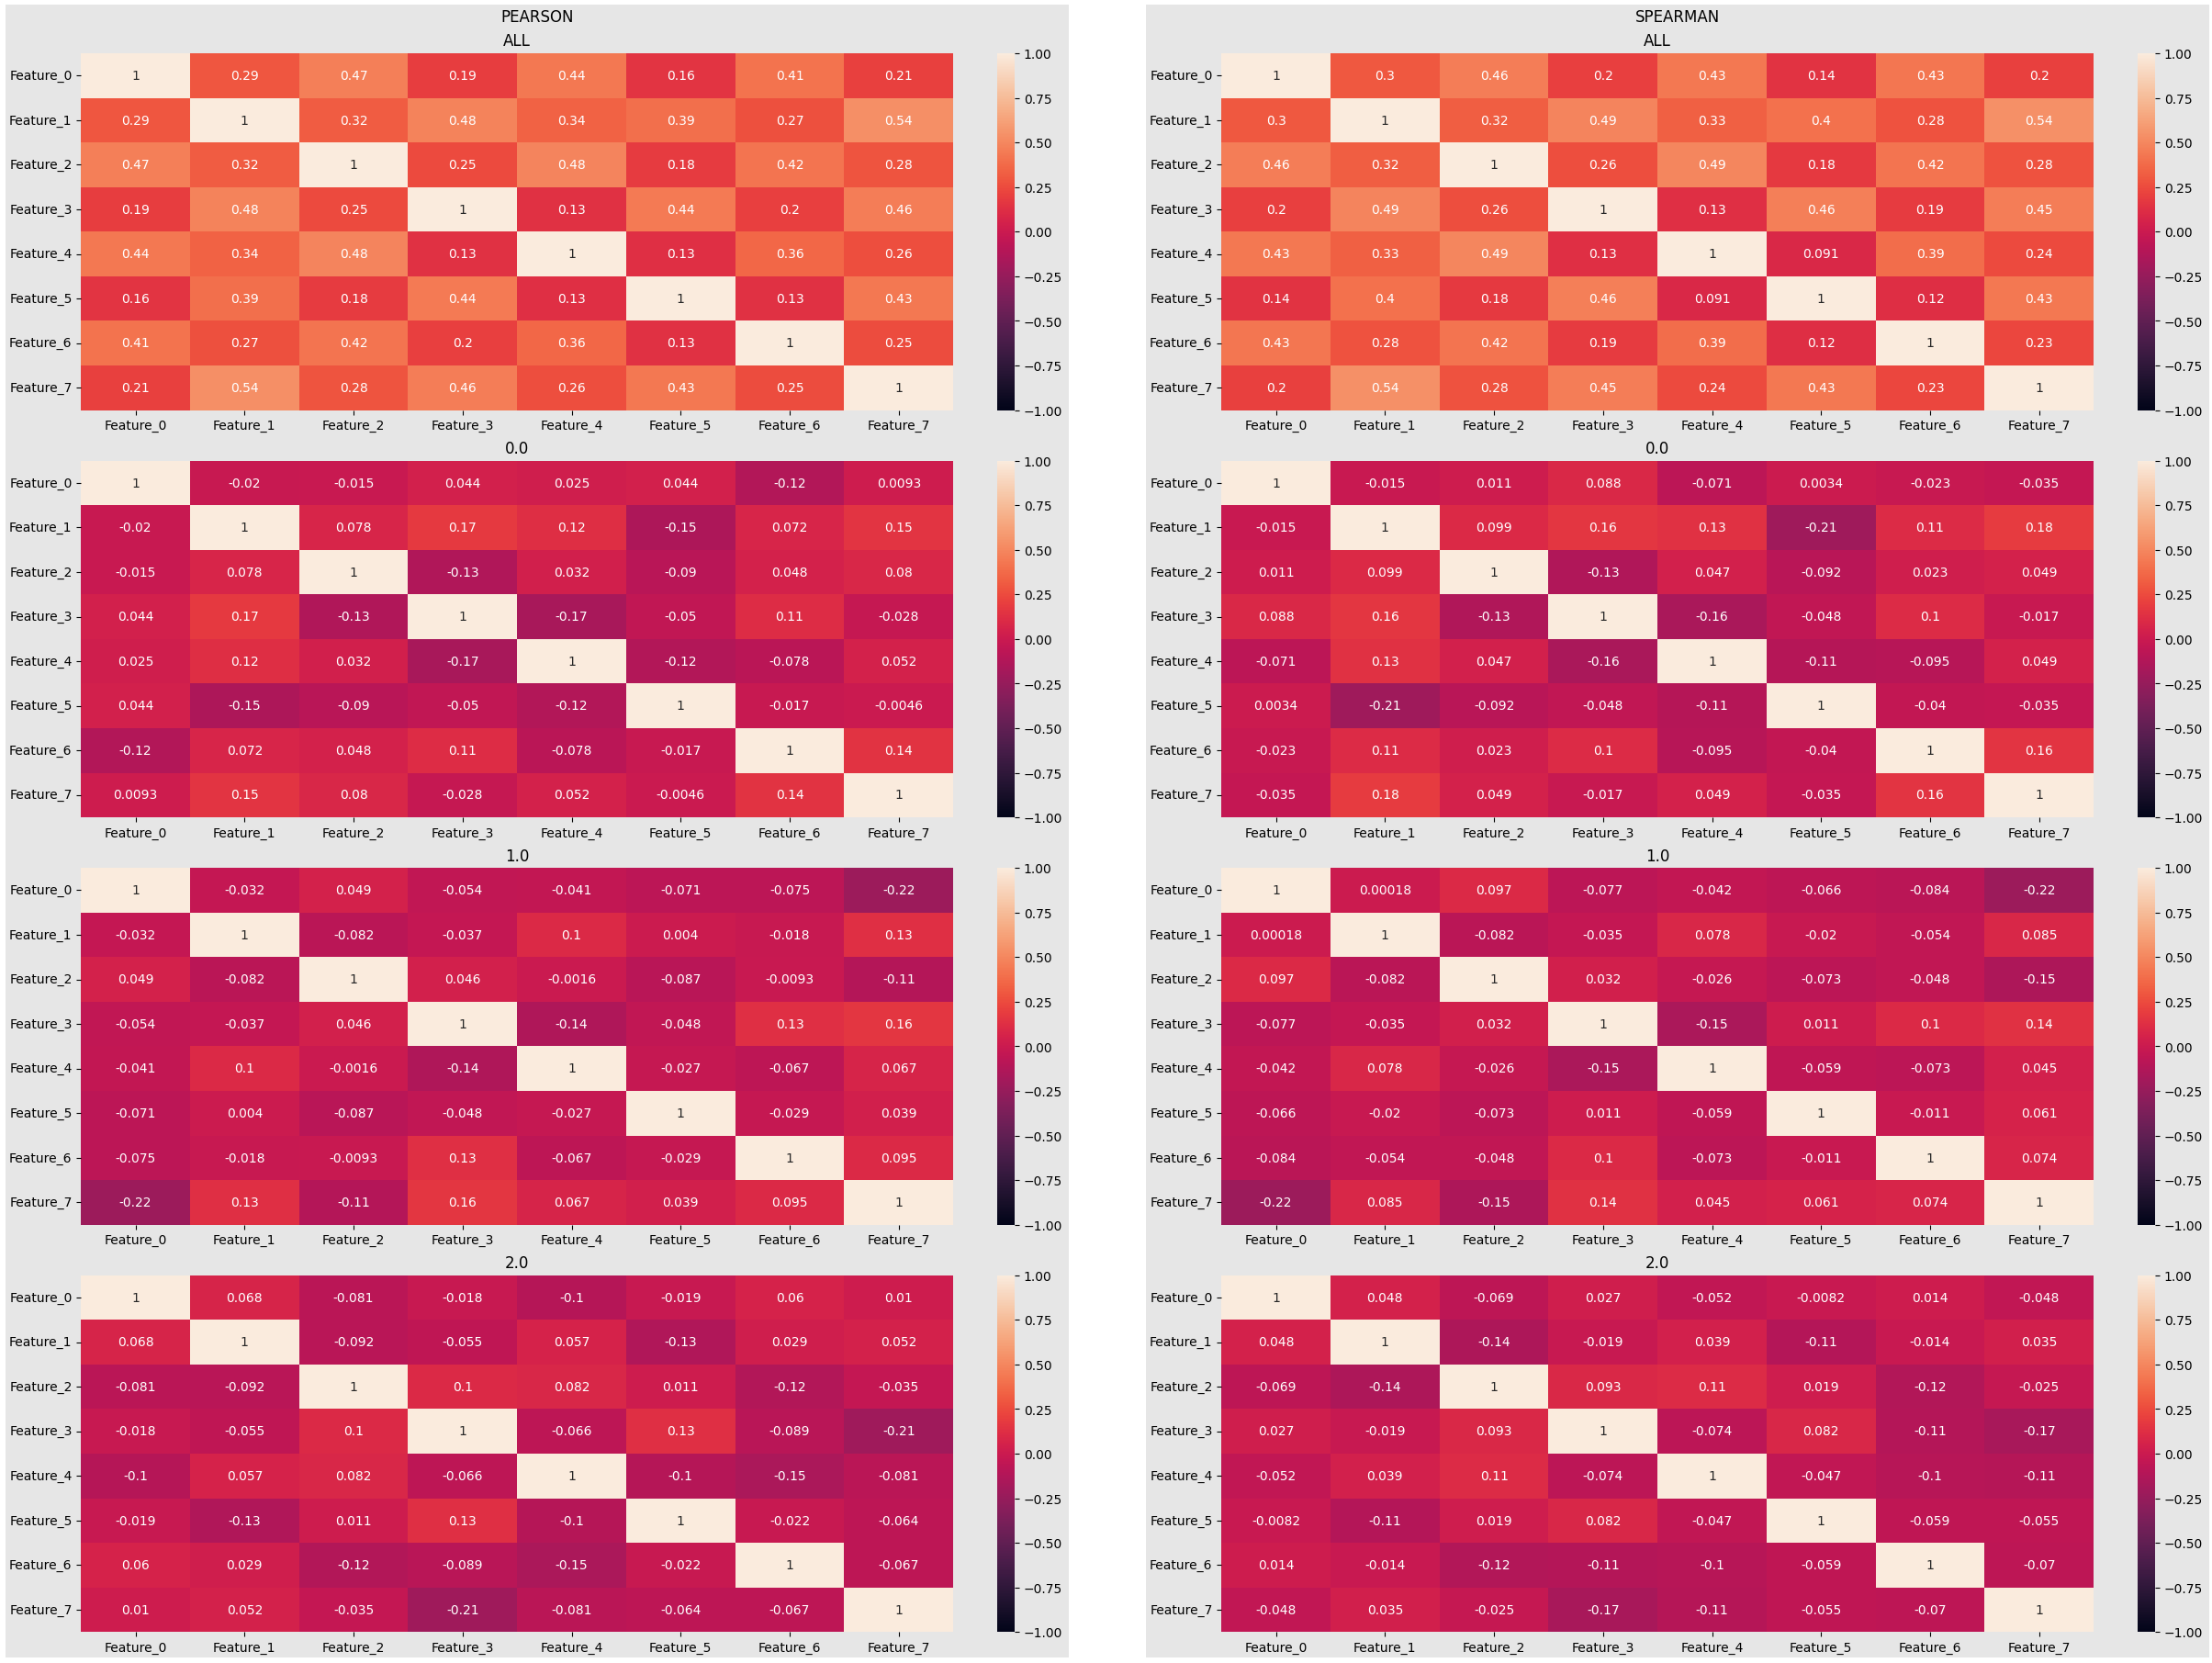

In [4]:
def compute_corr_matrix(df: pd.DataFrame, method: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    corr_and_p_value_matrix = []
    corr_matrix = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)
    corr_func = stats.pearsonr if method == "pearson" else stats.spearmanr

    for feature_1 in df.columns:
        for feature_2 in df.columns:
            res = corr_func(df[feature_1], df[feature_2])
            corr_matrix.at[feature_1, feature_2] = res.statistic
            corr_and_p_value_matrix.append({"feature_1": feature_1, 
                                            "feature_2": feature_2, 
                                            "corr": res.statistic, 
                                            "p_value": res.pvalue})

    return corr_matrix, pd.DataFrame(corr_and_p_value_matrix)


def draw_corr_matrices(all_objects: pd.DataFrame, objects_by_class: dict, class_labels: list) -> plt.Figure:
    fig = plt.figure(layout="constrained", figsize=[24, 18])
    subfigs = fig.subfigures(1, 2, wspace=0.07)

    for i, method in enumerate(["pearson", "spearman"]):
        print("\n\n", method.upper(), "\n", sep="")
        subfigs[i].suptitle(method.upper())
        subfigs[i].set_facecolor("0.9")
        axs = subfigs[i].subplots(4, 1)

        corr_matrix, corr_and_p_value_matrix = compute_corr_matrix(all_objects, method)
        print("All objects:", "\n", corr_and_p_value_matrix, sep="")
        sns.heatmap(corr_matrix, annot=True, ax=axs[0], vmin=-1, vmax=1)
        axs[0].set_title("ALL")
        for j, class_label in enumerate(class_labels):
            corr_matrix, corr_and_p_value_matrix = compute_corr_matrix(objects_by_class[class_label], method)
            print("\n", class_label, ":\n", corr_and_p_value_matrix, sep="")
            sns.heatmap(corr_matrix, annot=True, ax=axs[j + 1], vmin=-1, vmax=1)
            axs[j + 1].set_title(class_label)

    return fig


all_objects = df.drop(["Class"], axis=1)
objects_by_class = dict()
for class_label in class_labels:
    objects_by_class[class_label] = all_objects[df["Class"] == class_label]

corr_matrices_fig = draw_corr_matrices(all_objects, objects_by_class, class_labels)
plt.show()

## Задание 2
На основе созданного в пункте [1] датасета df сгенерировать отдельные
дополнительные датасеты (df_A_B),  
в которых к классу 0 добавлено A одинаковых точек
с координатами (-B,+B,-B,+B,-B,+B,-B,+B),  
где A = 1, 10, 100 и B = 1, 10, 100, при этом
количество объектов в остальных классах неизменно.

In [4]:
def make_df_a_b(df: pd.DataFrame, a: int, b: int, class_label: int) -> pd.DataFrame:
    new_elems = pd.DataFrame([[-b if (i % 2) == 0 else b for i in range(8)] + [class_label]] * a)
    new_elems.rename(columns=lambda i: f"Feature_{i}" if i != 8 else "Class", inplace=True)
    return pd.concat([df, pd.DataFrame(new_elems)], ignore_index=True)

In [7]:
A = [1, 10, 100]
B = [1, 10, 100]

df_a_b = {}
for a in A:
    df_b = {}
    for b in B:
        df_b[b] = make_df_a_b(df, a, b, 0)
        print(f"Common inforamtion about df_{a}_{b}:")
        display(describe_dataset(df_b[b], "Class"))
        display(df_b[b].tail())
        print()
    df_a_b[a] = df_b.copy()

Common inforamtion about df_1_1:


,Size,Features,Classes,0.0,1.0,2.0,Undefined
0,301,8,3,101,100,100,0.0


,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Class
296,-0.116524,0.235812,0.844102,-1.548287,1.160018,-0.498217,2.117399,0.448499,2.0
297,0.640231,-2.326048,0.586535,-0.739719,0.036241,-1.957151,1.343788,-1.048652,2.0
298,1.032797,-1.758495,0.769599,-1.924233,1.890198,0.035249,-0.846188,-1.929511,2.0
299,-0.496529,-1.650024,0.916562,-2.449645,0.078140,-2.003957,1.207267,-0.930656,2.0
300,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,0.0



Common inforamtion about df_1_10:


,Size,Features,Classes,0.0,1.0,2.0,Undefined
0,301,8,3,101,100,100,0.0


,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Class
296,-0.116524,0.235812,0.844102,-1.548287,1.160018,-0.498217,2.117399,0.448499,2.0
297,0.640231,-2.326048,0.586535,-0.739719,0.036241,-1.957151,1.343788,-1.048652,2.0
298,1.032797,-1.758495,0.769599,-1.924233,1.890198,0.035249,-0.846188,-1.929511,2.0
299,-0.496529,-1.650024,0.916562,-2.449645,0.078140,-2.003957,1.207267,-0.930656,2.0
300,-10.000000,10.000000,-10.000000,10.000000,-10.000000,10.000000,-10.000000,10.000000,0.0



Common inforamtion about df_1_100:


,Size,Features,Classes,0.0,1.0,2.0,Undefined
0,301,8,3,101,100,100,0.0


,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Class
296,-0.116524,0.235812,0.844102,-1.548287,1.160018,-0.498217,2.117399,0.448499,2.0
297,0.640231,-2.326048,0.586535,-0.739719,0.036241,-1.957151,1.343788,-1.048652,2.0
298,1.032797,-1.758495,0.769599,-1.924233,1.890198,0.035249,-0.846188,-1.929511,2.0
299,-0.496529,-1.650024,0.916562,-2.449645,0.078140,-2.003957,1.207267,-0.930656,2.0
300,-100.000000,100.000000,-100.000000,100.000000,-100.000000,100.000000,-100.000000,100.000000,0.0



Common inforamtion about df_10_1:


,Size,Features,Classes,0.0,1.0,2.0,Undefined
0,310,8,3,110,100,100,0.0


,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Class
305,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,0.0
306,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,0.0
307,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,0.0
308,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,0.0
309,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,0.0



Common inforamtion about df_10_10:


,Size,Features,Classes,0.0,1.0,2.0,Undefined
0,310,8,3,110,100,100,0.0


,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Class
305,-10.0,10.0,-10.0,10.0,-10.0,10.0,-10.0,10.0,0.0
306,-10.0,10.0,-10.0,10.0,-10.0,10.0,-10.0,10.0,0.0
307,-10.0,10.0,-10.0,10.0,-10.0,10.0,-10.0,10.0,0.0
308,-10.0,10.0,-10.0,10.0,-10.0,10.0,-10.0,10.0,0.0
309,-10.0,10.0,-10.0,10.0,-10.0,10.0,-10.0,10.0,0.0



Common inforamtion about df_10_100:


,Size,Features,Classes,0.0,1.0,2.0,Undefined
0,310,8,3,110,100,100,0.0


,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Class
305,-100.0,100.0,-100.0,100.0,-100.0,100.0,-100.0,100.0,0.0
306,-100.0,100.0,-100.0,100.0,-100.0,100.0,-100.0,100.0,0.0
307,-100.0,100.0,-100.0,100.0,-100.0,100.0,-100.0,100.0,0.0
308,-100.0,100.0,-100.0,100.0,-100.0,100.0,-100.0,100.0,0.0
309,-100.0,100.0,-100.0,100.0,-100.0,100.0,-100.0,100.0,0.0



Common inforamtion about df_100_1:


,Size,Features,Classes,0.0,1.0,2.0,Undefined
0,400,8,3,200,100,100,0.0


,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Class
395,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,0.0
396,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,0.0
397,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,0.0
398,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,0.0
399,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,0.0



Common inforamtion about df_100_10:


,Size,Features,Classes,0.0,1.0,2.0,Undefined
0,400,8,3,200,100,100,0.0


,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Class
395,-10.0,10.0,-10.0,10.0,-10.0,10.0,-10.0,10.0,0.0
396,-10.0,10.0,-10.0,10.0,-10.0,10.0,-10.0,10.0,0.0
397,-10.0,10.0,-10.0,10.0,-10.0,10.0,-10.0,10.0,0.0
398,-10.0,10.0,-10.0,10.0,-10.0,10.0,-10.0,10.0,0.0
399,-10.0,10.0,-10.0,10.0,-10.0,10.0,-10.0,10.0,0.0



Common inforamtion about df_100_100:


,Size,Features,Classes,0.0,1.0,2.0,Undefined
0,400,8,3,200,100,100,0.0


,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Class
395,-100.0,100.0,-100.0,100.0,-100.0,100.0,-100.0,100.0,0.0
396,-100.0,100.0,-100.0,100.0,-100.0,100.0,-100.0,100.0,0.0
397,-100.0,100.0,-100.0,100.0,-100.0,100.0,-100.0,100.0,0.0
398,-100.0,100.0,-100.0,100.0,-100.0,100.0,-100.0,100.0,0.0
399,-100.0,100.0,-100.0,100.0,-100.0,100.0,-100.0,100.0,0.0


## Задание 3
Выбрать пару классов 0 и 1, и один количественный признак.  

Для каждого из датасетов из списка (df, df_A_B) в своем пространстве Х-Y
(количественный признак-класс) построить и визуализировать объекты, линию линейной
регрессии и линию логистической регрессии. Регрессии строить на паре Х-Y(
количественный признак-класс).  

Оценить качество работы полученных на основе логистической регрессии
классификаторов, используя ROC кривые, восстановив на графике ROC кривых
определенную логистической регрессией точку классификации Sensitivity-Specificity и
оценные бутстрепом доверительные интервалы CI95 (n=1000).  

__Все полученные графики возможно расположить в две колонки: левая колонка – визуализация пространства и регрессий, правая – графики с ROC кривой и точкой.__

### Функция для отрисовки LogReg

In [103]:
def draw_logreg(logreg: LogisticRegression, X: np.ndarray, y: np.ndarray, ax: plt.Axes,
                class_0: int, class_1: int):
    ax.scatter(X[y == class_0], y[y == class_0], c=class_colors[class_0], marker=class_markers[class_0], 
               edgecolors="black", alpha=0.6, label=str(class_0), s=50)
    ax.scatter(X[y == class_1], y[y == class_1], c=class_colors[class_1], marker=class_markers[class_1], 
               edgecolors="black", alpha=0.6, label=str(class_1), s=50)
    
    y_pred = logreg.decision_function(X)
    ax.plot(X, y_pred, color="r", label="LinReg")

    x_min, x_max = X.min(), X.max()
    num_of_points = int((x_max - x_min) / 0.1)
    grid = np.linspace(x_min, x_max, num_of_points).reshape(-1, 1)
    y_probs = logreg.predict_proba(grid)[:, 1]
    ax.plot(grid, y_probs, "g-", lw=2.5, label="Sigmoid")

### Функции для отрисовки Confidence Bands

In [89]:
def compute_ci(arr: np.ndarray, ci: float):
    alpha = (1 - ci) / 2 
    percentiles = [100 * alpha, 100 * (1 - alpha)]
    return np.percentile(arr, percentiles, 0)


def draw_ci(x_metric_mean: np.ndarray, y_metric_ci: np.ndarray, ci: float, ax: plt.Axes, color: str = "b"):
    ax.fill_between(x_metric_mean, y_metric_ci[0], y_metric_ci[1], color=color, linewidth=2, alpha=0.3, label=f"ci = {ci:.2f}")

### Функции для построения и отрисовки ROC кривых (взято из лабораторной №2)

In [113]:
def specifity(TN: int, FP: int) -> float:
    return TN / (FP + TN) if (FP + TN) != 0 else 0


def sensitivity(TP: int, FN: int) -> float:
    return TP / (TP + FN) if (TP + FN) != 0 else 0


def compute_spec_and_sens(y_true: np.ndarray, y_pred: np.ndarray) -> tuple[float, float]:
    conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1])
    return specifity(conf_matrix[0, 0], conf_matrix[0, 1]), sensitivity(conf_matrix[1, 1], conf_matrix[1, 0])


def compute_roc_curve(y_true: np.ndarray, y_probs: np.ndarray, specifity_mean: np.ndarray,
                      thresholds: np.ndarray, compute_auc: bool = True) -> tuple[np.ndarray, float | None]:
    specifity_values = np.ndarray((thresholds.size))
    sensitivity_values = np.ndarray((thresholds.size))
    for i, threshold in enumerate(thresholds):
        y_pred = y_probs >= threshold
        specifity_values[i], sensitivity_values[i] = compute_spec_and_sens(y_true, y_pred)
    sensitivity_interp = np.interp(specifity_mean, specifity_values, sensitivity_values)
    auroc = auc(specifity_mean, sensitivity_interp) if compute_auc else None
    return sensitivity_interp, auroc


def draw_roc(specifity_mean: np.ndarray, sensitivity_interp: np.ndarray, auroc: float, ax: plt.Axes, color: str = "b"):
    ax.plot(specifity_mean, sensitivity_interp, color+"-", linewidth=3, label=f"ROC curve, AUROC = {auroc:.3f}")
    ax.set_xlim(1, 0)
    ax.set_xlabel("specifity")
    ax.set_ylim(0, 1)
    ax.set_ylabel("sensitivity")
    ax.grid()


def compute_roc_ci(specifity_mean: np.ndarray, y_true: pd.Series, y_probs: np.ndarray, 
                   n_bootstraps: int, ci: float, thresholds: np.ndarray) -> np.ndarray:
    sensitivity_interps = np.ndarray((n_bootstraps, specifity_mean.size))
    for i in range(n_bootstraps):
        y_true_resampled, y_probs_resampled = resample(y_true, y_probs, random_state=i)
        sensitivity_interps[i], _ = compute_roc_curve(y_true_resampled, y_probs_resampled, specifity_mean, thresholds, False)
    return compute_ci(sensitivity_interps, ci)

In [118]:
def add_decision_point_to_roc(y_true: np.ndarray, y_probs: np.ndarray, ax: plt.Axes):
    decision_point_spec, decision_point_sens = compute_spec_and_sens(y_true, y_probs >= 0.5)
    ax.scatter(decision_point_spec, decision_point_sens, color="green", zorder=3, s=50, 
                                    label=f"Decision point ({decision_point_spec:.2f}, {decision_point_sens:.2f})")
    ax.axvline(decision_point_spec, color="green", ls="--", zorder=3)

### Итоговая реализация

In [119]:
N_BOOTSTRAPS = 1000
CLASS_0 = 0
CLASS_1 = 1
FEATURES = ["Feature_0"]
CI = 0.95
THRESHOLDS = np.linspace(0, 1, 100)
SPECIFITY_MEAN = np.linspace(0, 1, 100)

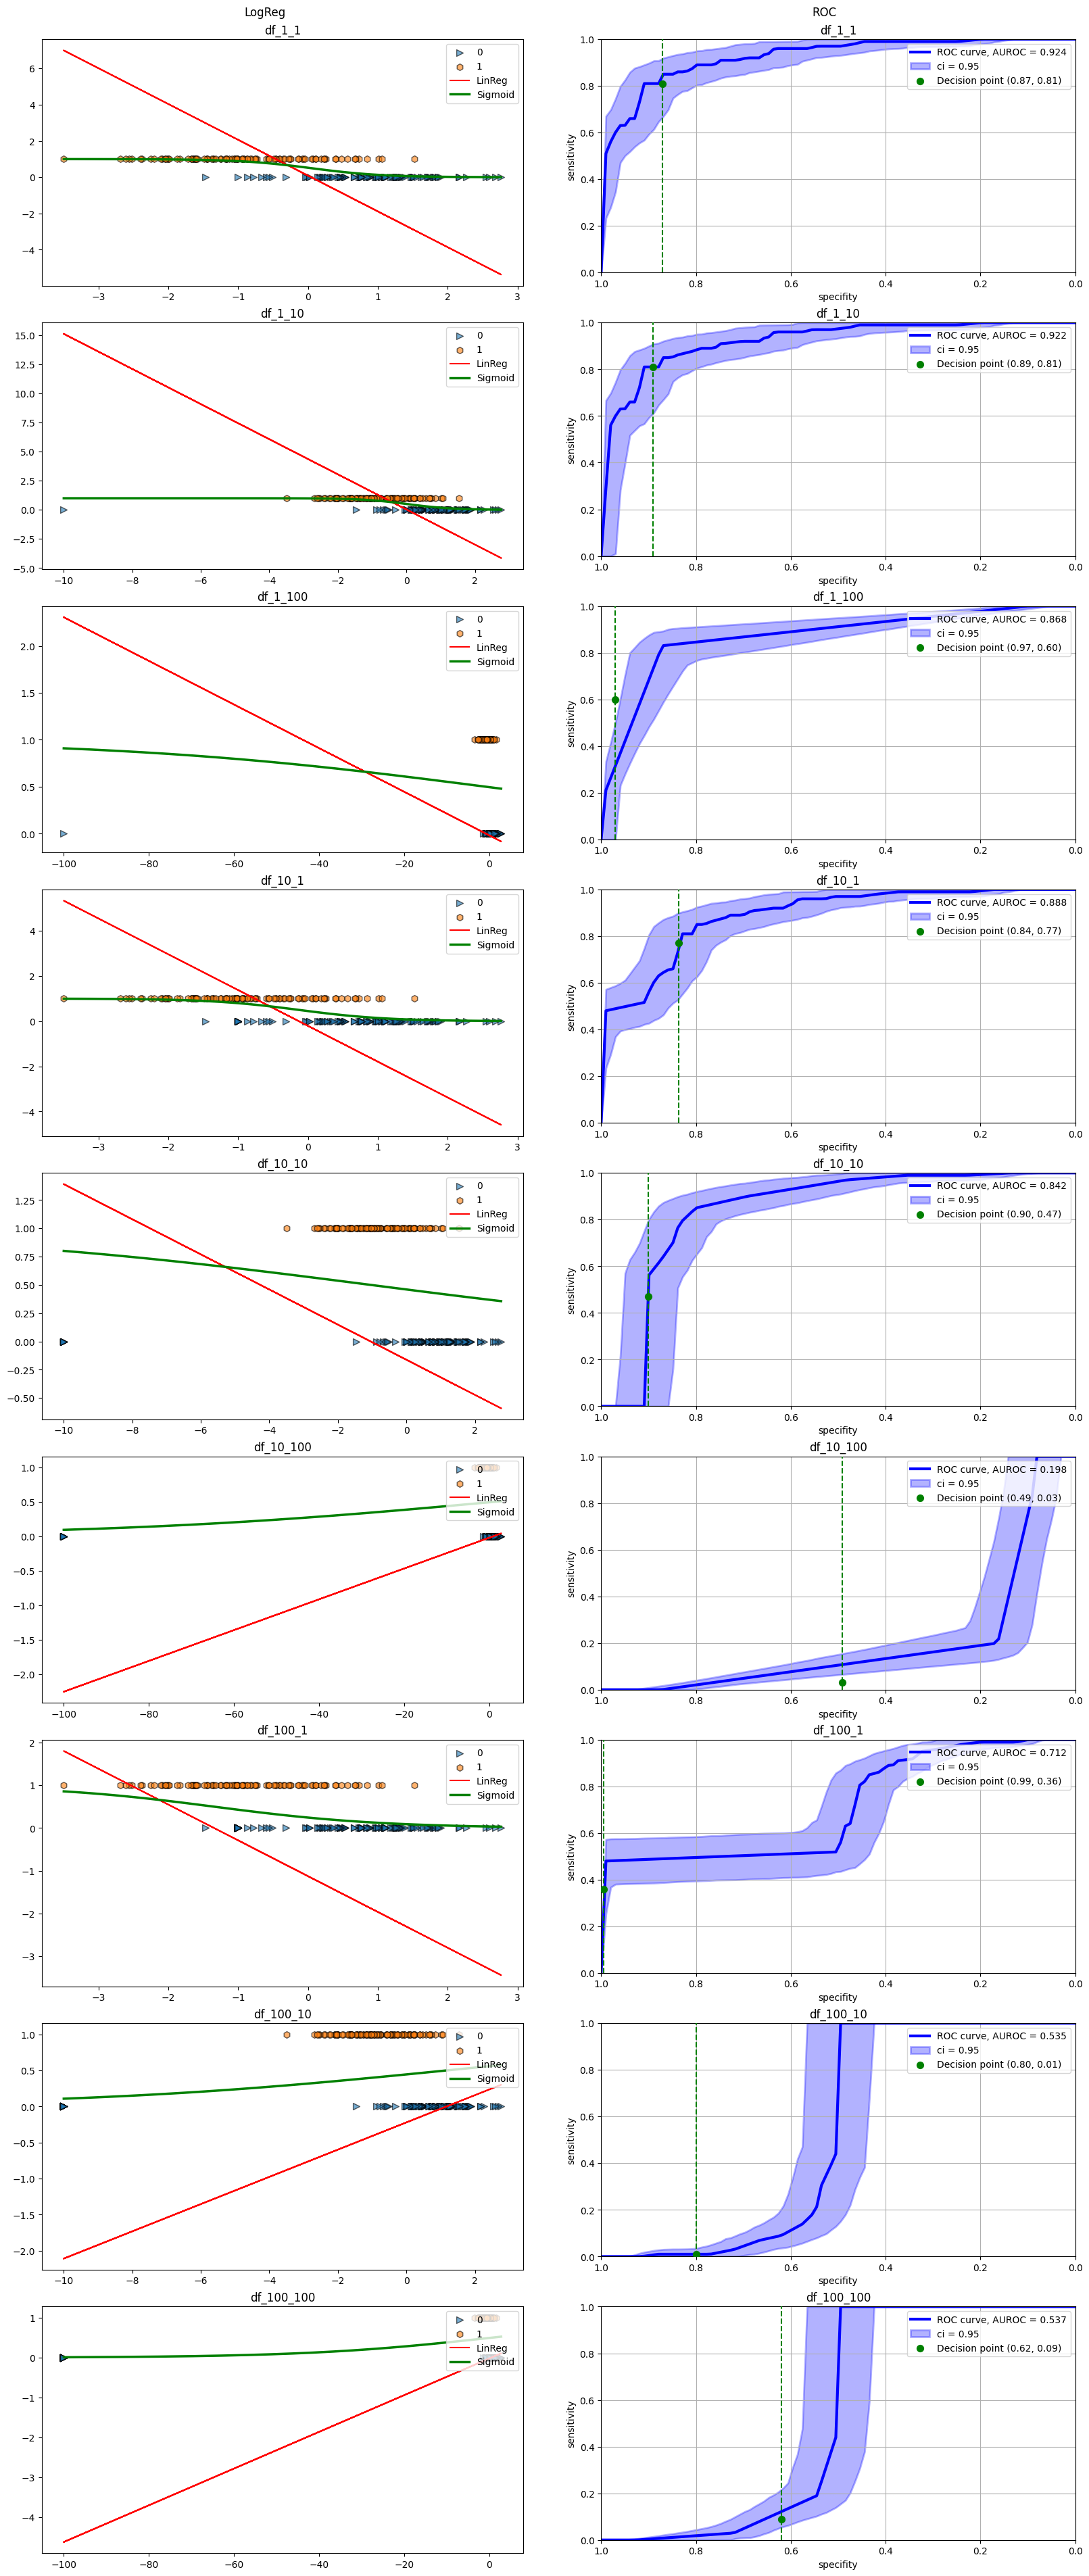

In [120]:
fig = plt.figure(layout="constrained", figsize=[16, 38])
subfigs = fig.subfigures(1, 2, wspace=0.07)
subfigs[0].suptitle("LogReg")
logreg_axs = subfigs[0].subplots(len(A) * len(B), 1)
subfigs[1].suptitle("ROC")
roc_axs = subfigs[1].subplots(len(A) * len(B), 1)

for i, a in enumerate(A):
    for j, b in enumerate(B):
        samples = df_a_b[a][b][(df_a_b[a][b]["Class"] == CLASS_0) | (df_a_b[a][b]["Class"] == CLASS_1)]
        X = samples[FEATURES].to_numpy().reshape(-1, 1)
        y = samples["Class"].to_numpy().ravel()

        logreg = LogisticRegression()
        logreg.fit(X, y)

        draw_logreg(logreg, X, y, logreg_axs[i * len(A) + j], CLASS_0, CLASS_1)
        logreg_axs[i * len(A) + j].set_title(f"df_{a}_{b}")
        logreg_axs[i * len(A) + j].legend(loc="upper right")

        y_probs = logreg.predict_proba(X)[:, 1]
        sensitivity_interp, auroc = compute_roc_curve(y, y_probs, SPECIFITY_MEAN, THRESHOLDS)
        draw_roc(SPECIFITY_MEAN, sensitivity_interp, auroc, roc_axs[i * len(A) + j])
        sensitivity_ci = compute_roc_ci(SPECIFITY_MEAN, y, y_probs, N_BOOTSTRAPS, CI, THRESHOLDS)
        draw_ci(SPECIFITY_MEAN, sensitivity_ci, CI, roc_axs[i * len(A) + j])
        add_decision_point_to_roc(y, y_probs, roc_axs[i * len(A) + j])
        roc_axs[i * len(A) + j].set_title(f"df_{a}_{b}")
        roc_axs[i * len(A) + j].legend(loc="upper right")